In [1]:
# Configuración de Entorno para trabajar con Procesamiento de Imágenes.
!pip install numpy scipy pillow matplotlib opencv-python-headless

In [2]:
import cv2
import numpy as np

import scipy.ndimage
from scipy.ndimage import convolve

import matplotlib.pyplot as plt
from google.colab import files
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr

In [3]:
# Función para subir 2 imágenes
def upload_images():
    print("Por favor, carga dos imágenes.")
    uploaded = files.upload()
    while len(uploaded) != 2:
        print("Debes cargar exactamente dos imágenes. Vuelve a intentarlo.")
        uploaded = files.upload()
    images = {}
    for filename in uploaded.keys():
        path = '/content/' + filename
        with open(path, 'wb') as f:
            f.write(uploaded[filename])
        image = cv2.imread(path)
        images[filename] = image
    return images

In [4]:
# Función para agregar ruido de sal y pimienta
def add_salt_and_pepper_noise(image, amount=0.01):
    num_rows, num_cols, num_channels = image.shape
    salt_vs_pepper_ratio = 0.5
    noisy_image = np.copy(image)

    # Añadir Sal
    num_salt_pixels = np.ceil(amount * image.size * salt_vs_pepper_ratio)
    salt_coords = [np.random.randint(0, dim_size - 1, int(num_salt_pixels)) for dim_size in image.shape]
    noisy_image[salt_coords[0], salt_coords[1], :] = 1

    # Añadir Pimienta
    num_pepper_pixels = np.ceil(amount * image.size * (1. - salt_vs_pepper_ratio))
    pepper_coords = [np.random.randint(0, dim_size - 1, int(num_pepper_pixels)) for dim_size in image.shape]
    noisy_image[pepper_coords[0], pepper_coords[1], :] = 0

    return noisy_image

In [5]:
# Técnica 1: Eliminación de ruido usando filtro de media a una imagen (NumPy y SciPy)
# Funciona tanto para imágenes en escala de grises como para imágenes a color.
# Parameters:
# image (numpy.ndarray): La imagen de entrada.
# kernel_size (int): El tamaño del kernel de filtrado. Debe ser un número impar.

# Returns:
# numpy.ndarray: La imagen filtrada.
def apply_mean_filter_custom(image, kernel_size=7):
   if len(image.shape) == 2:  # Imagen en escala de grises
        kernel = np.ones((kernel_size, kernel_size)) / (kernel_size * kernel_size)
        return convolve(image, kernel)
   elif len(image.shape) == 3:  # Imagen a color
        channels = []
        kernel = np.ones((kernel_size, kernel_size)) / (kernel_size * kernel_size)
        for i in range(image.shape[2]):
            channel = convolve(image[:, :, i], kernel)
            channels.append(channel)
        return np.stack(channels, axis=2)

In [6]:
# Técnica 2: Eliminación de ruido usando filtro de mediana a una imagen
# Aplicación del filtro de mediana a la imagen usando cv2.medianBlur
# image: La imagen a la que se aplicará el filtro
# kernel_size: El tamaño del kernel del filtro (debe ser un número impar)
def apply_median_filter(image, kernel_size=7):
    return cv2.medianBlur(image, kernel_size)

In [7]:
# Función de Visualización de Resultados
def display_and_evaluate(images):
    for name, data in images.items():
        original, noisy, mean_filtered, median_filtered = data
        print(f"\nImagen: {name}, Dimensiones: {original.shape}, Tamaño: {original.size} bytes")

        fig, axs = plt.subplots(1, 4, figsize=(18, 5))
        axs[0].imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB))
        axs[0].set_title('Imagen Original')
        axs[0].axis('off')

        axs[1].imshow(cv2.cvtColor(noisy, cv2.COLOR_BGR2RGB))
        axs[1].set_title('Imagen con Ruido')
        axs[1].axis('off')

        axs[2].imshow(cv2.cvtColor(mean_filtered, cv2.COLOR_BGR2RGB))
        axs[2].set_title('Imagen filtrada con Media')
        axs[2].axis('off')

        axs[3].imshow(cv2.cvtColor(median_filtered, cv2.COLOR_BGR2RGB))
        axs[3].set_title('Imagen filtrada con Mediana')
        axs[3].axis('off')

        plt.show()

        # Calcular Métricas PSNR and SSIM
        # PSNR (Peak Signal-to-Noise Ratio) y SSIM (Structural Similarity Index Measure)

        psnr_mean = psnr(cv2.cvtColor(original, cv2.COLOR_BGR2GRAY), cv2.cvtColor(mean_filtered, cv2.COLOR_BGR2GRAY))
        psnr_median = psnr(cv2.cvtColor(original, cv2.COLOR_BGR2GRAY), cv2.cvtColor(median_filtered, cv2.COLOR_BGR2GRAY))

        ssim_mean = ssim(cv2.cvtColor(original, cv2.COLOR_BGR2GRAY), cv2.cvtColor(mean_filtered, cv2.COLOR_BGR2GRAY))
        ssim_median = ssim(cv2.cvtColor(original, cv2.COLOR_BGR2GRAY), cv2.cvtColor(median_filtered, cv2.COLOR_BGR2GRAY))

        print(f"\nPSNR Media: {psnr_mean:.4f}, PSNR Mediana: {psnr_median:.4f}")
        print(f"SSIM Media: {ssim_mean:.4f}, SSIM Mediana: {ssim_median:.4f}\n")

Por favor, carga dos imágenes.


Saving Berna1.jpeg to Berna1.jpeg
Saving Colegas.JPG to Colegas.JPG

Imagen: Berna1.jpeg, Dimensiones: (1280, 959, 3), Tamaño: 3682560 bytes


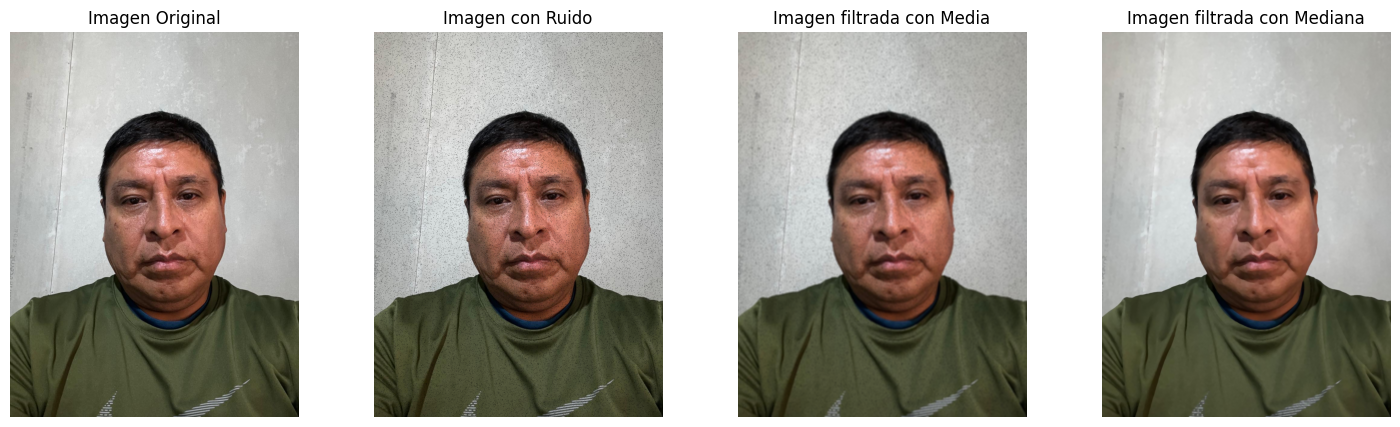


PSNR Media: 29.0982, PSNR Mediana: 33.1610
SSIM Media: 0.7839, SSIM Mediana: 0.8726


Imagen: Colegas.JPG, Dimensiones: (1200, 1600, 3), Tamaño: 5760000 bytes


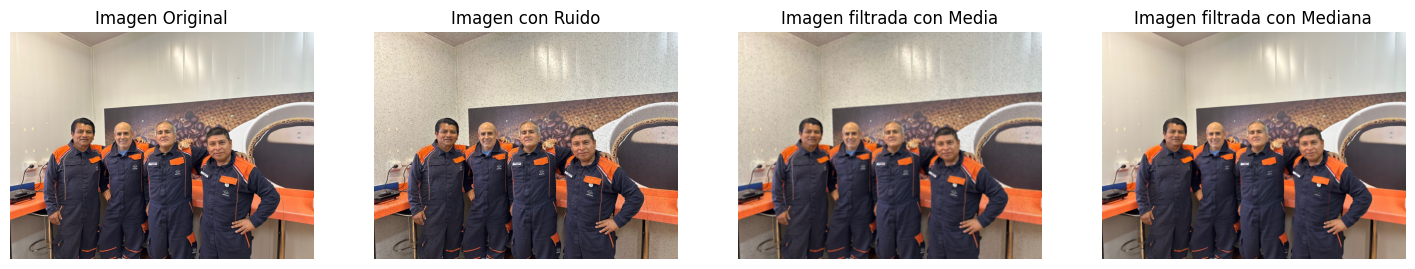


PSNR Media: 24.7108, PSNR Mediana: 26.5169
SSIM Media: 0.7287, SSIM Mediana: 0.8321



In [8]:
# Función Principal
def main():
    images = upload_images()
    processed_images = {}

    for name, image in images.items():
        noisy = add_salt_and_pepper_noise(image.copy())
        mean_filtered = apply_mean_filter_custom(noisy.copy())
        median_filtered = apply_median_filter(noisy.copy())
        processed_images[name] = (image, noisy, mean_filtered, median_filtered)

    display_and_evaluate(processed_images)

main()
